In [6]:
from keras.applications import VGG16
import os
from keras import layers, models
from keras import optimizers,losses
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
import gc
import numpy as np

In [2]:
orig_data_dir = 'D:\Deep-learning\\test-scripts\dogs-vs-cats\\train'
bas_dir = 'D:\Deep-learning\\test-scripts'

train_dir = os.path.join(bas_dir,'train')
print(train_dir)

val_dir = os.path.join(bas_dir,'val')
print(val_dir)

test_dir = os.path.join(bas_dir,'test')
print(test_dir)


D:\Deep-learning\test-scripts\train
D:\Deep-learning\test-scripts\val
D:\Deep-learning\test-scripts\test


In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150,150), batch_size=20, class_mode='binary')
val_generator = test_datagen.flow_from_directory(val_dir,target_size=(150,150), batch_size=20, class_mode='binary')
#test_generator = test_datagen.flow_from_directory(test_dir,target_size==(150,150), batch_size=20, class_mode='binary')



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))
conv_base.summary()

58892288/58889256 [==============================] - 4s 0us/step

In [5]:
batch_size = 20

def extract_features(dir, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = train_datagen.flow_from_directory(dir,target_size=(150,150),batch_size=batch_size,class_mode='binary')
    i=0
    for inputs_batch,labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i+=1
        if i*batch_size >= sample_count:
            break
    return features,labels

In [7]:
train_features,train_labels = extract_features(train_dir,2000)
val_features,val_labels = extract_features(val_dir,1000)
test_features,test_labels = extract_features(test_dir,1000)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
train_features = np.reshape(train_features,(2000,4*4*512))
val_features = np.reshape(val_features,(1000,4*4*512))
test_features = np.reshape(test_features,(1000,4*4*512))

In [9]:
model_final = models.Sequential()
model_final.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
model_final.add(layers.Dropout(0.5))
model_final.add(layers.Dense(1,activation='sigmoid'))

In [11]:
model_final.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])

In [12]:
history = model_final.fit(train_features,train_labels,epochs=30,batch_size=20,validation_data=(val_features,val_labels))

Epoch 1/30
100/100 [==============================] - 0s 4ms/step - loss: 0.6000 - acc: 0.6810 - val_loss: 0.4510 - val_acc: 0.8370
Epoch 2/30
100/100 [==============================] - 0s 2ms/step - loss: 0.4275 - acc: 0.8075 - val_loss: 0.3816 - val_acc: 0.8440
Epoch 3/30
100/100 [==============================] - 0s 2ms/step - loss: 0.3514 - acc: 0.8560 - val_loss: 0.3295 - val_acc: 0.8820

NameError: name 'model_basic' is not defined

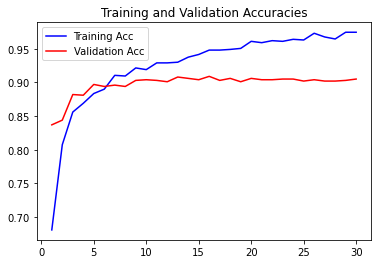

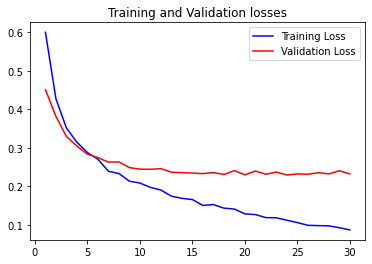

<Figure size 432x288 with 0 Axes>

In [13]:

acc  = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'b-',label='Training Acc')
plt.plot(epochs,val_acc,'r-',label='Validation Acc')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.figure()

epochs = range(1,len(acc)+1)
plt.plot(epochs,loss,'b-',label='Training Loss')
plt.plot(epochs,val_loss,'r-',label='Validation Loss')
plt.title('Training and Validation losses')
plt.legend()
plt.figure()

del history
#del model_basic
gc.collect()


In [14]:
conv_base.trainable=True
set_trainable = False
for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


In [15]:
model_fine_tune = models.Sequential()
model_fine_tune.add(conv_base)
model_fine_tune.add(layers.Flatten())
model_fine_tune.add(layers.Dense(256,activation='relu'))
model_fine_tune.add(layers.Dense(1,activation='sigmoid'))
model_fine_tune.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150,150),batch_size=20,class_mode='binary')
val_generator = test_datagen.flow_from_directory(val_dir,target_size=(150,150),batch_size=20,class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
model_fine_tune.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])

In [18]:
history = model_fine_tune.fit(train_generator,steps_per_epoch=100,epochs=30,validation_data=val_generator,validation_steps=50)

Epoch 1/30
100/100 [==============================] - 12s 118ms/step - loss: 0.4912 - acc: 0.7575 - val_loss: 0.2720 - val_acc: 0.8840

41817

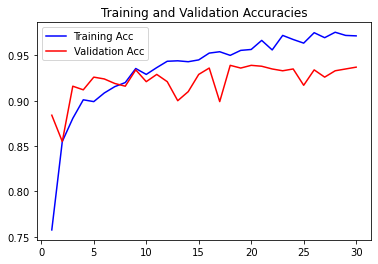

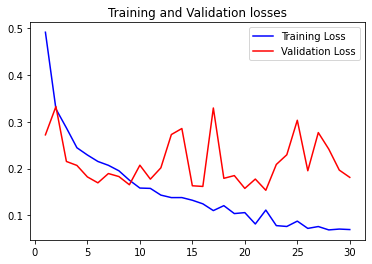

<Figure size 432x288 with 0 Axes>

In [19]:
acc  = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'b-',label='Training Acc')
plt.plot(epochs,val_acc,'r-',label='Validation Acc')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.figure()

epochs = range(1,len(acc)+1)
plt.plot(epochs,loss,'b-',label='Training Loss')
plt.plot(epochs,val_loss,'r-',label='Validation Loss')
plt.title('Training and Validation losses')
plt.legend()
plt.figure()

del history
#del model_basic
gc.collect()



In [20]:
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(150,150),batch_size=20,class_mode='binary')
test_loss,test_acc = model_fine_tune.evaluate(test_generator,steps=50)
print(test_acc,'\t',test_loss)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 2s 36ms/step - loss: 0.2491 - acc: 0.9350